# Tutorial: Ellipsometry problem setup

In [1]:
# install dependecies
!pip install pymoosh
!pip install nevergrad

## load modules

In [2]:
import nevergrad as ng
import matplotlib.pyplot as plt
import PyMoosh as pm
import numpy as np

## helper: define the optimization geometry

Here we define the geometric model to be optimized and its parametrization. We will optimize the thicknesses of a layer-stack of two alterning dielectric materials.
technically, the geometry is described by an instance of PyMoosh's `structure` class. The optimizer will generate sequences of floats. Therefore, we will write a wrapper that converts a list of thicknesses (provided by the optimizer) into a pymoosh structure object (required for the simulation). Furthermore, we also pass the additional fixed parameters that are not optimized by still needed for the structure description as keyword arguments. Here these are the material refractive indices of the two used dielectrics and of the environment.

In [3]:
def setup_structure(x, mat_env, mat_substrate):
    """helper to create pymoosh structure object with user-defined thicknesses and materials

    Args:
        X (list): long list of material permittivities and thicknesses (first half / second half)
        mat_env (float, str): material of environment (above stack)
        mat_substrate (float, str): material of substrate (below stack)

    Returns:
        PyMoosh.structure: multi-layer structure object
    """
    x = list(x)  # convert to list for convenience when stacking layers
    n_layers = len(x) // 2

    # available materials
    materials = [mat_env] + [_m for _m in x[:n_layers]] + [mat_substrate]
    # material sequence of layer-stack
    stack = [i for i in range(n_layers + 2)]
    # thicknesses of layers
    thicknesses = np.array([0] + [_t for _t in x[n_layers:]] + [0])

    structure = pm.Structure(
        materials, stack, np.array(thicknesses), verbose=False)

    return structure

## helper: define the optimization target

Now we define the physical property to be optimized - the *cost* function.
By default Nevergrad algorithms minimize the cost, so we will use $f_{cost} = 1-R$ in order to maximize the reflectivity of a layer stack.

In [4]:
# ------- the optimization target function -------
def cost_ellipsometry(x, ref_ellipso, mat_env, mat_substrate, wavelengths, angle):
    """ cost function: MAE between simulated and measured (ref) spectrum

    Args:
        x (list): materials (first half) & thicknesses (second half) of all layers
        ref_ellipso (np.ndarray): reference spectrum at `eval_wls`
        wavelengths (np.ndarray): wavelengths to evaluate

    Returns:
        float: 1 - Reflectivity at target wavelength
    """
    structure = setup_structure(x, mat_env, mat_substrate)

    # the actual PyMoosh reflectivity simulation
    ellips = np.zeros(len(wavelengths), dtype=np.complex128)
    for i, wav in enumerate(wavelengths):
        r_s, _, _, _ = pm.coefficient(structure, wav, angle, 0)
        r_p, _, _, _ = pm.coefficient(structure, wav, angle, 1)
        ellips[i] = r_p/r_s

    # diff = ellips - ref_ellipso
    cost = np.mean(np.abs(ellips.imag - ref_ellipso.imag)**2 +
                   np.abs(ellips.real - ref_ellipso.real)**2)

    return cost


## Setting up the optimization problem

Now we define the specific configuration of our optimization problem. For ellipsometry we generate a random layer structure (=the reference) and calculate the spectrum of the complex ratio r_p/r_s. This is equivalent to the measurement in an actual experiment.

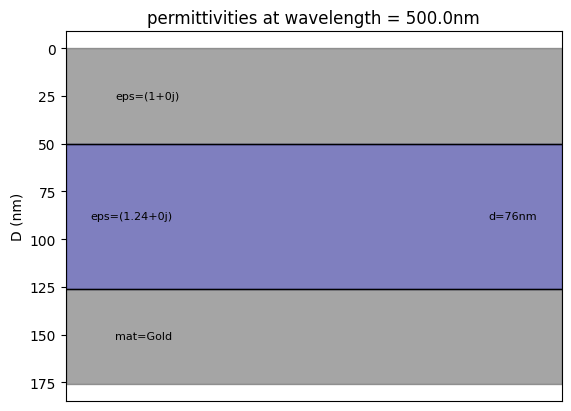

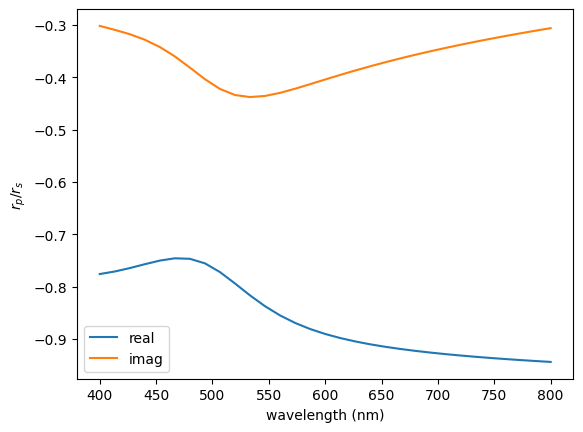

In [5]:
# ------- define "ellispometry" optimization problem
mat_env = 1.0
mat_substrate = 'Gold'
nb_layers = 1
min_thick = 50     # nm
max_thick = 150
min_eps = 1.1      # permittivity
max_eps = 3
wavelengths = np.linspace(400, 800, 31)  # nm
angle = 40*np.pi/180  # rad

# create a reference structure that we then try to find
x_ref = [np.random.random()*(max_eps-min_eps) + min_eps for _ in range(nb_layers)]
x_ref += [np.random.random()*(max_thick-min_thick) + min_thick for _ in range(nb_layers)]
struct_ref = setup_structure(x_ref, mat_env, mat_substrate)

# calculate reference r_p/r_s spectrum (equiv. to ellispometry measurement)
ref_ellipso = np.zeros(len(wavelengths), dtype=complex)
for i, wav in enumerate(wavelengths):
    r_s, _, _, _ = pm.coefficient(struct_ref, wav, angle, 0)
    r_p, _, _, _ = pm.coefficient(struct_ref, wav, angle, 1)
    ref_ellipso[i] = r_p / r_s


# plot reference
plt.figure()
plt.subplot(title='reference structure (which we try to find via ellipsometry)')
struct_ref.plot_stack()

plt.figure()
plt.plot(wavelengths, ref_ellipso.real, label='real')
plt.plot(wavelengths, ref_ellipso.imag, label='imag')
plt.legend()
plt.xlabel('wavelength (nm)')
plt.ylabel('$r_p / r_s$')
plt.show()


## Setup the Nevergrad optimizer

Now we set up the parametrization for nevergrad (this is called *instrumentation*).
Finally, we configure the optimizer.

In [6]:
# ------- setup the parametrization
budget = 100     # stop criterion: allowed number of evaluations

# parametrization
# bounds for free params: layer permittivities and thicknesses
args_mat_thick_ng = ng.p.Array(
    init=[min_eps]*nb_layers + [min_thick]*nb_layers,
    lower=[min_eps]*nb_layers + [min_thick]*nb_layers,
    upper=[max_eps]*nb_layers + [max_thick]*nb_layers,
)

# wrap free and fixed arguments
instrumentation = ng.p.Instrumentation(
    # --- optimization args
    x=args_mat_thick_ng,

    # --- additional, fixed args
    ref_ellipso=ref_ellipso,
    mat_env=mat_env,
    mat_substrate=mat_substrate,
    wavelengths=wavelengths,
    angle=angle,
)


# ------- setup the optimizer
# configure specific variant from BFGS optimizer family
optim_algos_BFGS = ng.optimizers.registry['BFGS']

# initialize the optimizer
optimizer = optim_algos_BFGS(instrumentation, budget=budget)

## run the optimization

Running the optimization is straightforward. We simply pass the cost function (`cost_ellispometry`) to the `minimize` function of the optimizer. The problem is configured inside the optimzer object and cost function.

In [7]:
x_opt = optimizer.minimize(cost_ellipsometry)

## analyze the result

Finally, we calculate the spectrum for the final best solution and plot the results:

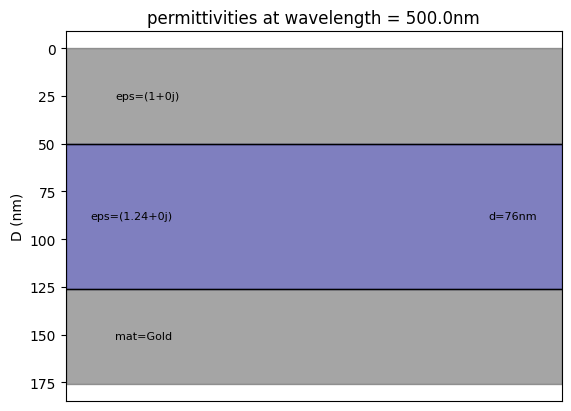

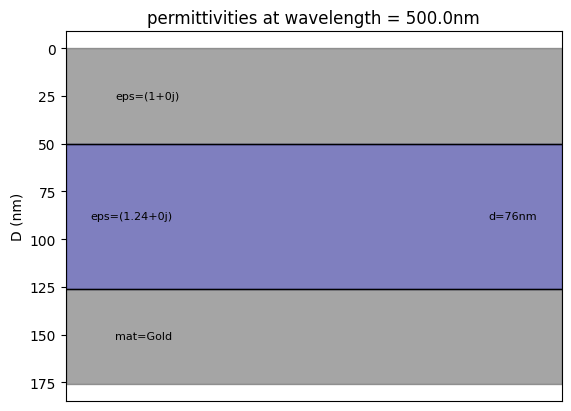

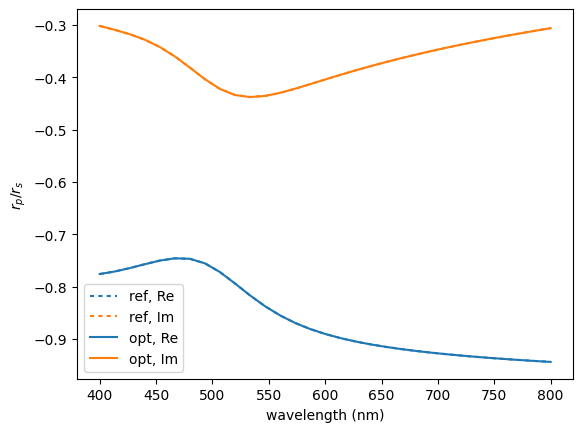

In [8]:
x = x_opt.value[1]['x']
struct_opt = setup_structure(x, mat_env, mat_substrate)

# calculate reference r_p/r_s spectrum (equiv. to ellispometry measurement)
opt_ellipso = np.zeros(len(wavelengths), dtype=complex)
for i, wav in enumerate(wavelengths):
    r_s, _, _, _ = pm.coefficient(struct_opt, wav, angle, 0)
    r_p, _, _, _ = pm.coefficient(struct_opt, wav, angle, 1)
    opt_ellipso[i] = r_p / r_s

ellips = opt_ellipso


# plot reference
plt.figure()
plt.subplot(title='reference layer')
struct_ref.plot_stack()
plt.figure()
plt.subplot(title='optimized result')
struct_opt.plot_stack()

plt.figure()
plt.plot(wavelengths, ref_ellipso.real, label='ref, Re', color='C0', dashes=[2,2])
plt.plot(wavelengths, ref_ellipso.imag, label='ref, Im', color='C1', dashes=[2,2])
plt.plot(wavelengths, opt_ellipso.real, label='opt, Re', color='C0')
plt.plot(wavelengths, opt_ellipso.imag, label='opt, Im', color='C1')
plt.legend()
plt.xlabel('wavelength (nm)')
plt.ylabel('$r_p / r_s$')
plt.show()
